#Partiendo de la limpieza de datos realizada previamente, se utiliza LSTM para predecir la producción de pozos de petroleo.

###Pozos a predecir:
158364, 160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237, 163942





In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

idpozo = 160211
model_save_path_50trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}-50trials.h5"
image_save_path_50trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}-50trials.png"
image_save_path_three_lastmonths_50trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}three_lastmonths-50trials.png"


model_save_path_100trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}-100trials.h5"
image_save_path_100trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}-100trials.png"
image_save_path_three_lastmonths_100trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}three_lastmonths-100trials.png"

model_save_path_mse_mae_100trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}-mse_mae-100trials.h5"
image_save_path_mse_mae_100trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}-mse_mae_100-trials.png"
image_save_path_three_lastmonths_mse_mae_100trials = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/{idpozo}/best_lstm_model_{idpozo}three_lastmonths_mse_mae-100trials.png"

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

dataset = pd.read_csv("/content/drive/MyDrive/Trabajo profesional/Code/data/prod_norm_2024-05-27_03:42:59.csv", index_col=0)

dataset = dataset[dataset['anio'] >= 2014]

# Seleccionar características relevantes
features = ['prod_pet', 'prod_gas', 'anio', 'mes', 'idpozo', 'prod_agua', 'tef', 'coordenadax', 'coordenaday', 'cota', 'areayacimiento']

# Filtrar características
data = dataset[features]

# Creacion de una nueva columna 'date' combinando 'anio' y 'mes' para representar la fecha
data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')

data.drop(['mes', 'anio'], axis=1, inplace=True)

# Conversion de la columna 'date' a "datetime type"
data['date'] = pd.to_datetime(data['date'])

# Definicion de un dia de referencia inicial (Es la primera fecha desde la que se filtro previamente).
reference_date = pd.Timestamp('2014-01-01')

# Calculo del numero de meses desde la referencia para cada date.
data['date_numeric'] = (data['date'].dt.year - reference_date.year) * 12 + data['date'].dt.month - reference_date.month + 1

data.drop(['date'], axis=1, inplace=True)

# Agrupar por 'areayacimiento' y 'date_numeric' para calcular el promedio de 'prod_gas'
grouped = data.groupby(['areayacimiento', 'date_numeric'])['prod_gas'].mean().reset_index()

# Renombrar la columna 'prod_gas' a 'prom_prod_gas'
grouped = grouped.rename(columns={'prod_gas': 'prom_prod_gas'})

# Unir el promedio calculado con el DataFrame original
data = pd.merge(data, grouped, on=['areayacimiento', 'date_numeric'])

filtered_data_one_id = data[data['idpozo'] == idpozo]

filtered_data_one_id.drop(['idpozo'], axis=1, inplace=True)
filtered_data_one_id.drop(['areayacimiento'], axis=1, inplace=True)

Mounted at /content/drive


<ipython-input-1-60a7aeda4f69>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['anio'].astype(str) + '-' + data['mes'].astype(str), format='%Y-%m')
<ipython-input-1-60a7aeda4f69>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['mes', 'anio'], axis=1, inplace=True)
<ipython-input-1-60a7aeda4f69>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [2]:
filtered_data_one_id.head()

,prod_pet,prod_gas,prod_agua,tef,coordenadax,coordenaday,cota,date_numeric,prom_prod_gas
44901,4491.0655,756.849,3520.812,30.000,-68.676031,-38.225002,353.6,64,697.797000
46237,6452.3330,748.773,1707.176,30.990,-68.676031,-38.225002,353.6,65,688.194750
47584,5506.0690,588.129,1153.977,29.996,-68.676031,-38.225002,353.6,66,512.525500
48945,4823.0620,541.169,741.911,30.854,-68.676031,-38.225002,353.6,67,470.785250
50322,4371.4455,389.676,540.964,30.935,-68.676031,-38.225002,353.6,68,547.917143


1/1 [==============================] - 0s 200ms/step

1/1 [==============================] - 0s 241ms/step

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 184ms/step

  8%|▊         | 4/50 [01:14<15:39, 20.42s/trial, best loss: 867.4392016666666] 

1/1 [==============================] - 0s 178ms/step

 10%|█         | 5/50 [01:26<13:01, 17.37s/trial, best loss: 867.4392016666666]

1/1 [==============================] - 0s 177ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 180ms/step

1/1 [==============================] - 0s 169ms/step

1/1 [==============================] - 0s 170ms/step

1/1 [==============================] - 0s 259ms/step

1/1 [==============================] - 0s 206ms/step

1/1 [==============================] - 0s 175ms/step

1/1 [==============================] - 0s 174ms/step

1/1 [==============================] - 0s 208ms/step

1/1 [==============================] - 0s 172ms/step

1/1 [==============================] - 0s 184ms/step

1/1 [==============================] - 0s 170ms/step

1/1 [==============================] - 0s 180ms/step

1/1 [==============================] - 0s 188ms/step

1/1 [==============================] - 0s 176ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 249ms/step

1/1 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 171ms/step
Error Cuadrático Medio: 10607.907276757109
Error Absoluto Medio: 100.38148555501301


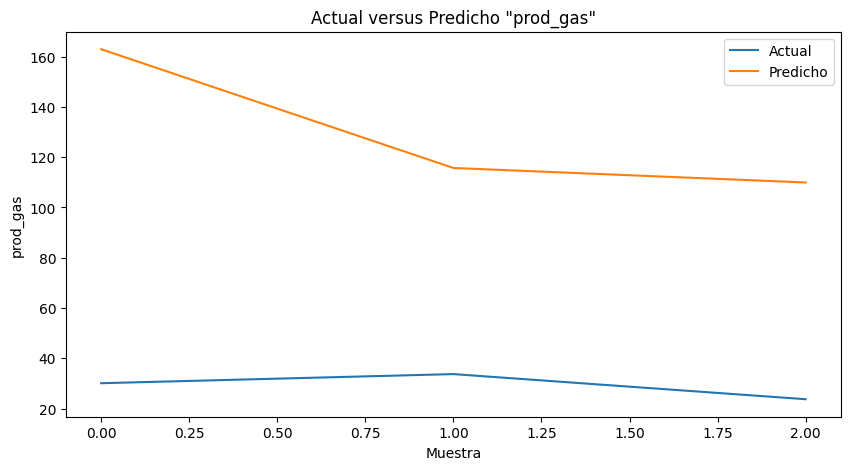

1/1 [==============================] - 0s 21ms/step
Predicciones para valores futuros de prod_gas: [ 89.60217 110.47762  96.83308 108.74125 120.37317 125.95935 131.45665
 136.59932]


In [3]:
# 50 Trials - mse only

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'prom_prod_gas', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_gas']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)
# Calcular el índice de corte para los últimos 3 valores (121, 122 y 123)
test_size = 3
split_index = len(X_sequences) - test_size

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_adjusted[:split_index], y_adjusted[split_index:]


# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

model.save(model_save_path_50trials)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_gas')
plt.title('Actual versus Predicho "prod_gas"')
plt.legend()
plt.savefig(image_save_path_50trials)
plt.show()

# Predecir "prod_gas" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [121, 122, 123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'prom_prod_gas': [filtered_data_one_id['prom_prod_gas'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_gas:", predictions.flatten())


Valores reales de prod_gas para date_numeric 121, 122 y 123: [30.076 33.702 23.705]
Valores predichos de prod_gas para date_numeric 121, 122 y 123: [ 89.60217 110.47762  96.83308]


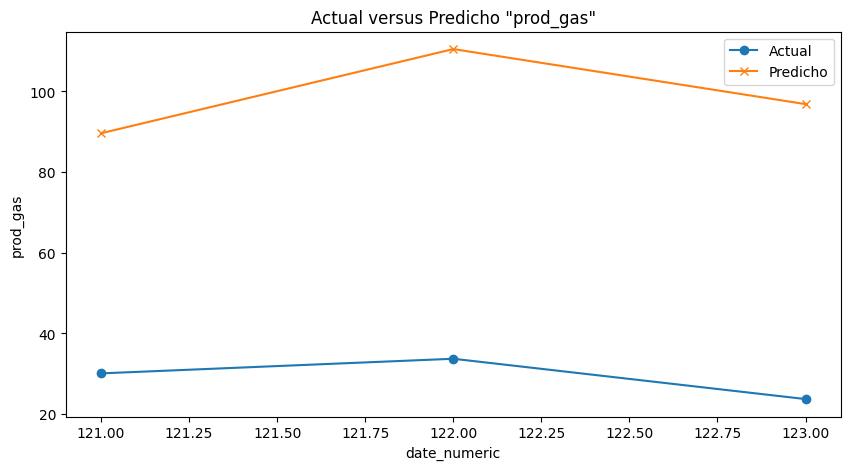

In [4]:
import matplotlib.pyplot as plt

# Filtrar los datos de prueba para los valores de date_numeric 121, 122 y 123
test_data = filtered_data_one_id[filtered_data_one_id['date_numeric'].isin([121, 122, 123])]

# Extraer la columna de 'prod_gas' para los valores de date_numeric 121, 122 y 123
real_values = test_data['prod_gas'].values

# Obtener las predicciones para los valores de date_numeric 121, 122 y 123
# Aquí 'predictions' se supone que contiene las predicciones de los valores futuros
predicted_values = predictions[:3].flatten()

# Imprimir los valores reales de prod_gas para date_numeric 121, 122 y 123
print("Valores reales de prod_gas para date_numeric 121, 122 y 123:", real_values)

# Imprimir los valores predichos de prod_gas para date_numeric 121, 122 y 123
print("Valores predichos de prod_gas para date_numeric 121, 122 y 123:", predicted_values)

# Graficar los valores reales vs los valores predichos
plt.figure(figsize=(10, 5))
plt.plot([121, 122, 123], real_values, label='Actual', marker='o')
plt.plot([121, 122, 123], predicted_values, label='Predicho', marker='x')
plt.xlabel('date_numeric')
plt.ylabel('prod_gas')
plt.title('Actual versus Predicho "prod_gas"')
plt.legend()
plt.savefig(image_save_path_three_lastmonths_50trials)
plt.show()

In [5]:
# Load the existing CSV file

csv_results_file_path = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/predictions_agregacion_MSE_50_trials.csv"
df = pd.read_csv(csv_results_file_path)

# Determine the current maximum index in the DataFrame
#max_index = df.index.max()

# Create a DataFrame with the new data, ensuring the indices are sequential from the current maximum index
#new_indices = [max_index + 1, max_index + 2, max_index + 3]

# Create a DataFrame with the new data
new_data = {
    'fecha': ['2024-01-01', '2024-02-01', '2024-03-01'],
    'idpozo': [idpozo, idpozo, idpozo],
    'prod_gas':predicted_values
}

new_df = pd.DataFrame(new_data)
combined_df = pd.concat([df, new_df], ignore_index=True)
combined_df.to_csv(csv_results_file_path, index=False)

#new_df = pd.DataFrame(new_data, index=new_indices)
#combined_df = pd.concat([df, new_df])
#combined_df.to_csv(csv_results_file_path, index=True, index_label='')

print(f'Nuevo valor agregado al csv {csv_results_file_path}')

Nuevo valor agregado al csv /content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/predictions_agregacion_MSE_50_trials.csv


1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 206ms/step

1/1 [==============================] - 0s 199ms/step

1/1 [==============================] - 0s 173ms/step

1/1 [==============================] - 0s 173ms/step

1/1 [==============================] - 0s 201ms/step

1/1 [==============================] - 0s 184ms/step

1/1 [==============================] - 0s 186ms/step

1/1 [==============================] - 0s 290ms/step

1/1 [==============================] - 0s 210ms/step

1/1 [==============================] - 0s 184ms/step

1/1 [==============================] - 0s 199ms/step

1/1 [==============================] - 0s 179ms/step

1/1 [==============================] - 0s 205ms/step

1/1 [==============================] - 0s 201ms/step

1/1 [==============================] - 0s 180ms/step

1/1 [==============================] - 0s 223ms/step

1/1 [==============================] - 0s 347ms/step

1/1 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 182ms/step
Error Cuadrático Medio: 867.4392016666666
Error Absoluto Medio: 29.161


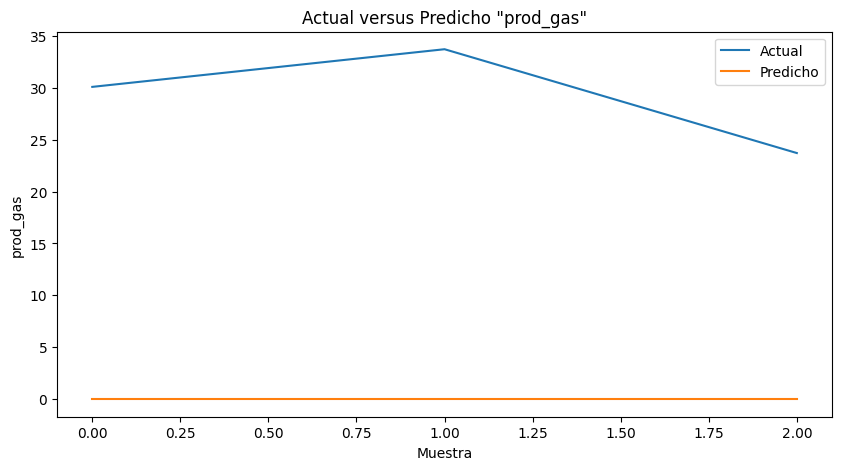

1/1 [==============================] - 0s 21ms/step
Predicciones para valores futuros de prod_gas: [0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
#Funcion objetivo mse y mae - 100 trials

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'prom_prod_gas', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_gas']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)
# Calcular el índice de corte para los últimos 3 valores (121, 122 y 123)
test_size = 3
split_index = len(X_sequences) - test_size

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_adjusted[:split_index], y_adjusted[split_index:]

# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, la combinación de MSE y MAE)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Calcular el MSE y MAE
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

    # Combinar MSE y MAE en una única métrica
    combined_metric = 0.5 * mse + 0.5 * mae
    return combined_metric

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)  # Aumentar max_evals

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

model.save(model_save_path_mse_mae_100trials)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_gas')
plt.title('Actual versus Predicho "prod_gas"')
plt.legend()
plt.savefig(image_save_path_mse_mae_100trials)
plt.show()

# Predecir "prod_gas" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [121, 122, 123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'prom_prod_gas': [filtered_data_one_id['prom_prod_gas'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_gas:", predictions.flatten())


Valores reales de prod_gas para date_numeric 121, 122 y 123: [30.076 33.702 23.705]
Valores predichos de prod_gas para date_numeric 121, 122 y 123: [0. 0. 0.]


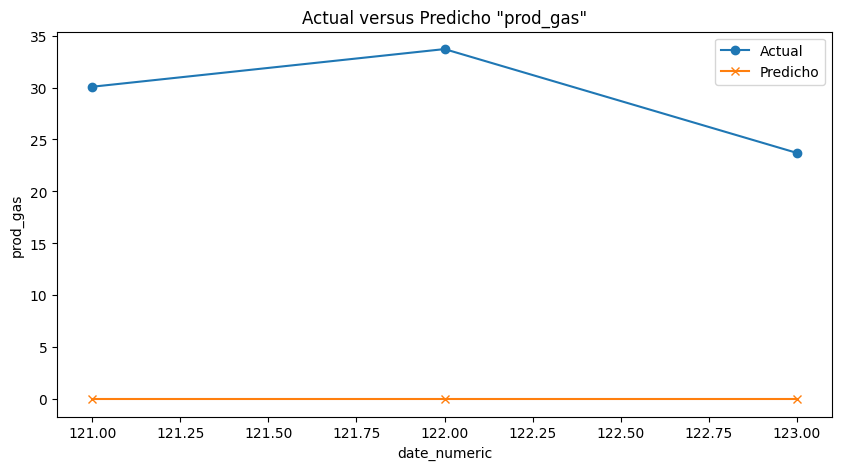

In [7]:
import matplotlib.pyplot as plt

# Filtrar los datos de prueba para los valores de date_numeric 121, 122 y 123
test_data = filtered_data_one_id[filtered_data_one_id['date_numeric'].isin([121, 122, 123])]

# Extraer la columna de 'prod_gas' para los valores de date_numeric 121, 122 y 123
real_values = test_data['prod_gas'].values

# Obtener las predicciones para los valores de date_numeric 121, 122 y 123
# Aquí 'predictions' se supone que contiene las predicciones de los valores futuros
predicted_values = predictions[:3].flatten()

# Imprimir los valores reales de prod_gas para date_numeric 121, 122 y 123
print("Valores reales de prod_gas para date_numeric 121, 122 y 123:", real_values)

# Imprimir los valores predichos de prod_gas para date_numeric 121, 122 y 123
print("Valores predichos de prod_gas para date_numeric 121, 122 y 123:", predicted_values)

# Graficar los valores reales vs los valores predichos
plt.figure(figsize=(10, 5))
plt.plot([121, 122, 123], real_values, label='Actual', marker='o')
plt.plot([121, 122, 123], predicted_values, label='Predicho', marker='x')
plt.xlabel('date_numeric')
plt.ylabel('prod_gas')
plt.title('Actual versus Predicho "prod_gas"')
plt.legend()
plt.savefig(image_save_path_three_lastmonths_mse_mae_100trials)
plt.show()

In [8]:
# Load the existing CSV file

csv_results_file_path = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/predictions_agregacion_MSE_MAE_100_trials.csv"
df = pd.read_csv(csv_results_file_path)

# Determine the current maximum index in the DataFrame
#max_index = df.index.max()

# Create a DataFrame with the new data, ensuring the indices are sequential from the current maximum index
#new_indices = [max_index + 1, max_index + 2, max_index + 3]

# Create a DataFrame with the new data
new_data = {
    'fecha': ['2024-01-01', '2024-02-01', '2024-03-01'],
    'idpozo': [idpozo, idpozo, idpozo],
    'prod_gas':predicted_values
}

new_df = pd.DataFrame(new_data)
combined_df = pd.concat([df, new_df], ignore_index=True)
combined_df.to_csv(csv_results_file_path, index=False)

#new_df = pd.DataFrame(new_data, index=new_indices)
#combined_df = pd.concat([df, new_df])
#combined_df.to_csv(csv_results_file_path, index=True, index_label='')

print(f'Nuevo valor agregado al csv {csv_results_file_path}')

Nuevo valor agregado al csv /content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/predictions_agregacion_MSE_MAE_100_trials.csv


1/1 [==============================] - 0s 267ms/step

1/1 [==============================] - 0s 187ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [==============================] - 0s 297ms/step

1/1 [==============================] - 0s 278ms/step

1/1 [==============================] - 0s 181ms/step

1/1 [==============================] - 0s 195ms/step

1/1 [==============================] - 0s 178ms/step

1/1 [==============================] - 0s 176ms/step

1/1 [==============================] - 0s 185ms/step

1/1 [==============================] - 0s 172ms/step

1/1 [==============================] - 0s 207ms/step

1/1 [==============================] - 0s 197ms/step

1/1 [==============================] - 0s 280ms/step

1/1 [==============================] - 0s 192ms/step

1/1 [==============================] - 0s 193ms/step

1/1 [==============================] - 0s 195ms/step

1/1 [==============================] - 0s 189ms/step

1/1 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 184ms/step
Error Cuadrático Medio: 2610.6837576835146
Error Absoluto Medio: 50.41135209147135


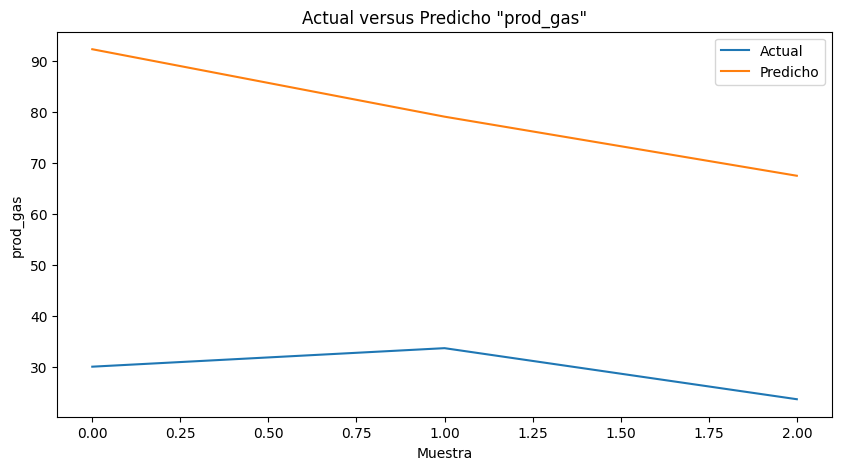

1/1 [==============================] - 0s 22ms/step
Predicciones para valores futuros de prod_gas: [36.387268 10.788583  9.354377 18.739283 28.232536 36.88479  45.69862
 54.664623]


In [9]:
# Con 100 Trials - mse only

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials

# "X" contiene los features
X = filtered_data_one_id[['tef', 'coordenadax', 'coordenaday', 'cota', 'prom_prod_gas', 'date_numeric']]

# "y" contiene la columna que es la variable objetivo a predecir.
y = filtered_data_one_id['prod_gas']

# Escalar las características entre 0 y 1
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Escalar la variable objetivo entre 0 y 1
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Longitud de la secuencia
seq_length = 3

# Función para crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Crear secuencias para LSTM
X_sequences = create_sequences(X_scaled, seq_length)

# Ajustar "y" para que coincida con las secuencias
y_adjusted = y_scaled[seq_length - 1:]

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_adjusted, test_size=0.2, random_state=42, shuffle=False)
# Calcular el índice de corte para los últimos 3 valores (121, 122 y 123)
test_size = 3
split_index = len(X_sequences) - test_size

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
y_train, y_test = y_adjusted[:split_index], y_adjusted[split_index:]


# Definir el espacio de búsqueda de hiperparámetros
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
    'epochs': hp.choice('epochs', [100, 200, 300, 400])
}

# Función objetivo para minimizar (en este caso, el error cuadrático medio)
def objective(params):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
        Dense(1),
        Activation('relu')  # Asegurar que las predicciones sean no negativas
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
    return mse

# Ejecutar la búsqueda de hiperparámetros
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# Obtener los mejores hiperparámetros
best_batch_size = [16, 32, 64, 128][best['batch_size']]
best_epochs = [100, 200, 300, 400][best['epochs']]

print(f'Mejor tamaño de lote: {best_batch_size}')
print(f'Mejor cantidad de épocas: {best_epochs}')

# Construir el modelo final con los mejores hiperparámetros
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(1),
    Activation('relu')  # Asegurar que las predicciones sean no negativas
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=1)

model.save(model_save_path_100trials)

# Predecir en el conjunto de prueba
y_pred_scaled = model.predict(X_test)

# Inversión del escalado para obtener las predicciones reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculo de métricas de error
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred)
mae = mean_absolute_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'Error Absoluto Medio: {mae}')

# Graficar los valores predichos vs los valores reales
plt.figure(figsize=(10, 5))
plt.plot(scaler_y.inverse_transform(y_test), label='Actual')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Muestra')
plt.ylabel('prod_gas')
plt.title('Actual versus Predicho "prod_gas"')
plt.legend()
plt.savefig(image_save_path_100trials)
plt.show()

# Predecir "prod_gas" para los siguientes valores futuros de "date_numeric"
future_date_numeric_values = [121, 122, 123, 124, 125, 126, 127, 128]

# Crear un DataFrame con los valores futuros y placeholders para las demás características
future_data = pd.DataFrame({
    'tef': [filtered_data_one_id['tef'].iloc[-1]] * len(future_date_numeric_values),
    'coordenadax': [filtered_data_one_id['coordenadax'].iloc[-1]] * len(future_date_numeric_values),
    'coordenaday': [filtered_data_one_id['coordenaday'].iloc[-1]] * len(future_date_numeric_values),
    'cota': [filtered_data_one_id['cota'].iloc[-1]] * len(future_date_numeric_values),
    'prom_prod_gas': [filtered_data_one_id['prom_prod_gas'].iloc[-1]] * len(future_date_numeric_values),
    'date_numeric': future_date_numeric_values
})

# Escalar los datos futuros
scaled_future_data = scaler_X.transform(future_data)

# Crear secuencias para LSTM usando los datos futuros escalados
last_sequence = X_scaled[-seq_length:]
future_sequences = []
for i in range(len(future_date_numeric_values)):
    new_sequence = np.append(last_sequence[1:], [scaled_future_data[i]], axis=0)
    future_sequences.append(new_sequence)
    last_sequence = new_sequence
future_sequences = np.array(future_sequences)

# Hacer predicciones (escaladas - no valores reales)
predictions_scaled = model.predict(future_sequences)

# Inversión del escalado para obtener las predicciones reales
predictions = scaler_y.inverse_transform(predictions_scaled)

print("Predicciones para valores futuros de prod_gas:", predictions.flatten())


In [ ]:
import matplotlib.pyplot as plt

# Filtrar los datos de prueba para los valores de date_numeric 121, 122 y 123
test_data = filtered_data_one_id[filtered_data_one_id['date_numeric'].isin([121, 122, 123])]

# Extraer la columna de 'prod_gas' para los valores de date_numeric 121, 122 y 123
real_values = test_data['prod_gas'].values

# Obtener las predicciones para los valores de date_numeric 121, 122 y 123
# Aquí 'predictions' se supone que contiene las predicciones de los valores futuros
predicted_values = predictions[:3].flatten()

# Imprimir los valores reales de prod_gas para date_numeric 121, 122 y 123
print("Valores reales de prod_gas para date_numeric 121, 122 y 123:", real_values)

# Imprimir los valores predichos de prod_gas para date_numeric 121, 122 y 123
print("Valores predichos de prod_gas para date_numeric 121, 122 y 123:", predicted_values)

# Graficar los valores reales vs los valores predichos
plt.figure(figsize=(10, 5))
plt.plot([121, 122, 123], real_values, label='Actual', marker='o')
plt.plot([121, 122, 123], predicted_values, label='Predicho', marker='x')
plt.xlabel('date_numeric')
plt.ylabel('prod_gas')
plt.title('Actual versus Predicho "prod_gas"')
plt.legend()
plt.savefig(image_save_path_three_lastmonths_100trials)
plt.show()

In [11]:
# Load the existing CSV file

csv_results_file_path = f"/content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/predictions_agregacion_MSE_100_trials.csv"
df = pd.read_csv(csv_results_file_path)

# Determine the current maximum index in the DataFrame
#max_index = df.index.max()

# Create a DataFrame with the new data, ensuring the indices are sequential from the current maximum index
#new_indices = [max_index + 1, max_index + 2, max_index + 3]

# Create a DataFrame with the new data
new_data = {
    'fecha': ['2024-01-01', '2024-02-01', '2024-03-01'],
    'idpozo': [idpozo, idpozo, idpozo],
    'prod_gas':predicted_values
}

new_df = pd.DataFrame(new_data)
combined_df = pd.concat([df, new_df], ignore_index=True)
combined_df.to_csv(csv_results_file_path, index=False)

#new_df = pd.DataFrame(new_data, index=new_indices)
#combined_df = pd.concat([df, new_df])
#combined_df.to_csv(csv_results_file_path, index=True, index_label='')

print(f'Nuevo valor agregado al csv {csv_results_file_path}')

Nuevo valor agregado al csv /content/drive/MyDrive/Trabajo profesional/Code/LSTM/Modelos/predictions_agregacion_MSE_100_trials.csv
